In [78]:
import tensorflow as tf
#!/bin/bash -c "source /home/user/.bashrc"

%env TF_MODELS="/home/andreikvasov/repos/tensorflow/models"
#%env TF_MIN_GPU_MULTIPROCESSOR_COUNT=2

env: TF_MODELS="/home/andreikvasov/repos/tensorflow/models"


In [79]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy
import pandas as pd
import tensorflow as tf
import time

import sys
# export PYTHONPATH=$PYTHONPATH:/home/andreikvasov/repos/tensorflow/models/research/slim
from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

#import argparse
import os

#from tensorflow.contrib.learn.python.learn.datasets import mnist

import tarfile
import gzip


# from six.moves import xrange  # pylint: disable=redefined-builtin
# from tensorflow.contrib.learn.python.learn.datasets import base
# from tensorflow.python.framework import dtypes
# from tensorflow.python.framework import random_seed

In [80]:
multi_fov_dataset = '/home/andreikvasov/Documents/FOV/FOV problem/'
write_tfread_to = multi_fov_dataset
multi_fov_dir=multi_fov_dataset

In [91]:
dataset_prefix = 'rpg_vfr_'
cam_type = 'pinhole'
dir_path = os.path.join(write_tfread_to, dataset_prefix+cam_type)
img_dir = os.path.join(dir_path, 'data')


img_w, img_h = 640, 480

# READ DATA from tar files

In [92]:
def read_data_sets(train_dir,
                   cam_types=[],
                   dtype=tf.uint8,
                   reshape=False,
                   write_tfread_to=multi_fov_dataset,
                   multi_fov_dir=multi_fov_dataset,
                   validation_size=0.25,
                   seed=None, make_dataset=False):
    
    images=[]
    for cam_type in cam_types:
        dir_path = os.path.join(write_tfread_to, dataset_prefix+cam_type)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        # groundtruths and 
        filename = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'_info.tar.gz')
        if not os.path.exists(filename):
            print('Download pinhole dataset. No pinhole extracted.')
            continue
        baz = tarfile.open(filename, 'r:gz')
        gt_txt = None
        with open(os.path.join(dir_path,'groundtruth.txt'), 'w') as f:
            f.write(baz.extractfile(baz.getmember('info/groundtruth.txt')).read())
        print(dir_path + '/groundtruth.txt')
        gt_txt=pd.read_table(dir_path + '/groundtruth.txt', header=None, index_col=0, sep='\s+',
                            names=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
        print(gt_txt.shape)#, gt_txt.index.values, gt_txt.size)
        #print(gt_txt.iloc[-1])
        im_txt = None
        with open(os.path.join(dir_path,'images.txt'), 'w') as f:
            f.write(baz.extractfile(baz.getmember('info/images.txt')).read())  
        print(dir_path + '/images.txt')
        im_txt=pd.read_table(dir_path + '/images.txt', header=None, index_col=0,sep='\s+',
                    names=['image_id', 'timestamp', 'path_to_img'])

        print(im_txt.shape)#, im_txt.index.values)

        # image to tfread
        filename = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'_data.tar.gz')
        baz = tarfile.open(filename, 'r:gz')
        if (not os.path.exists(os.path.join(dir_path, 'data/img'))):
            baz.extractall(dir_path)
        else:
            if not os.listdir(os.path.join(dir_path, 'data/img')): 
                baz.extractall(dir_path)
        print(im_txt.shape, im_txt.index.values, im_txt.size)
        #images.append(extract_images(dir_path, size=im_txt.shape[0]))
        
    if not make_dataset:
        return
    
    images = np.concatenate(images, axis=0)
    gt_txt['timestamp'] = im_txt['timestamp']
    labels = gt_txt.values

    train_size = images.shape[0]
    if validation_size < 1:
        val_size = int(train_size*validation_size)
    else:
        if not 0 <= validation_size <= len(images):
            raise ValueError(
                'Validation size should be between 0 and {}. Received: {}.'
                .format(len(images), validation_size))
        val_size = int(validation_size)

    validation_images = images[:val_size]
    validation_labels = labels[:val_size]
    train_images = images[val_size:]
    train_labels = labels[val_size:]


    options = dict(dtype=dtype, reshape=reshape, seed=seed)

    train = DataSet(train_images, train_labels, **options)
    validation = DataSet(validation_images, validation_labels, **options)
    test = DataSet(images, labels, **options)

    return base.Datasets(train=train, validation=validation, test=test)

In [95]:
FLAGS.cam_types = ['cata', 'fisheye', 'pinhole']

In [96]:
read_data_sets(None, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_cata/groundtruth.txt
(200, 7)
/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_cata/images.txt
(200, 2)
(200, 2) [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200] 400
/home/andreik

# Main

In [9]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz" # github models 
checkpoints_dir = multi_fov_dir

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

#Uncomment if to download pretrained net`    
dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


In [10]:
import numpy as np
import os
import tensorflow as tf

#from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

from tensorflow.contrib.tensorboard.plugins import projector

In [97]:
FLAGS = tf.flags.FLAGS

cnt = 0
len_name = len('img0001_0.png')

image_size = vgg.vgg_16.default_image_size
filenames_list = []
cam_types = ['pinhole', 'fisheye', 'cata']
passing = [1]#*3#, 5]
dataset_dir = os.path.join(multi_fov_dir, dataset_prefix+'_'.join(cam_types))
img_dir = os.path.join(multi_fov_dir, dataset_prefix+'_'.join(cam_types)+'/data/img')
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [99]:
filenames_list = []
gt_txt = None
for cam_type, step in zip(cam_types, passing):
    cur_filenames_list = []
    cur_img_dir = os.path.join(multi_fov_dir, dataset_prefix+cam_type+'/data/img')
    print(cur_img_dir)
    cur_filenames_list += [os.path.abspath(os.path.join(cur_img_dir, img_name)) 
                               for img_name in np.sort(os.listdir(cur_img_dir))
                               if 'png' in img_name and 'sprite' not in img_name and cam_type not in img_name ][::step]
    cur_dir = os.path.join(multi_fov_dir, dataset_prefix+cam_type)
    cur_gt_txt=pd.read_table(cur_dir + '/groundtruth.txt', header=None, index_col=0, sep='\s+',
                            names=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'])
    cur_im_txt=pd.read_table(cur_dir + '/images.txt', header=None, index_col=0,sep='\s+',
                    names=['image_id', 'timestamp', 'path_to_img'])
    merged_txt = cur_gt_txt
    merged_txt['timestamp'] = cur_im_txt['timestamp']
    merged_txt['path_to_img'] = [cam_type + '_' + x[-len_name:] for x in cur_im_txt['path_to_img']]
    if gt_txt is None:
        gt_txt = merged_txt.iloc[::step]
    else:
        index = merged_txt.index
        names = 'image_id'
        index = (index.values + gt_txt.shape[0]).astype(np.int)
        merged_txt.index = pd.Index(index, names = names)
        gt_txt = pd.concat((gt_txt, merged_txt.iloc[::step]))

    for name in cur_filenames_list:
        new_name = os.path.join(img_dir, cam_type +'_'+name[-(len_name):])
        if not os.path.exists(new_name):
            os.system("cp '{0:}' '{1:}'".format(name, new_name))
        filenames_list += [new_name]

gt_txt.to_csv(os.path.join(dataset_dir, 'img_groundtruth.txt'), sep=' ', 
          columns=['image_id', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw', 'timestamp', 'path_to_img'])

/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole/data/img


In [100]:
N = len(filenames_list)
D = 4096

FLAGS.batch_size = 25
FLAGS.min_queue_size = 1
FLAGS.num_examples = len(filenames_list)
FLAGS.num_threads = 2
FLAGS.num_epochs = 1

LOG_DIR = img_dir
print(N, filenames_list)

200 ['/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0001_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0002_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0003_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0004_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0005_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0006_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0007_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0008_0.png', '/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole_fisheye_cata/data/img/pinhole_img0009_0.png', '/home/andreikvasov/Doc

In [15]:
def read_my_file_format(filename_queue, sess):
    reader = tf.WholeFileReader()
    key, value = reader.read(filename_queue)
    #?tf.Print(key, [key])
    my_img = tf.image.decode_png(value, channels=3) # use png or jpg decoder based on your files
    processed_image = vgg_preprocessing.preprocess_image(my_img, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    #print(processed_images.shape)
    return processed_images, tf.constant([1], dtype=dtypes.int8)


def input_pipeline(filenames_list, batch_size=FLAGS.batch_size, 
                   read_threads=FLAGS.num_threads, num_epochs=None, shuffle=False,
                   session=None):
    filename_queue = tf.train.string_input_producer(
        filenames_list, num_epochs=num_epochs, shuffle=shuffle)
    example_list = [read_my_file_format(filename_queue, sess)
                  for _ in range(read_threads)]
    min_after_dequeue = FLAGS.min_queue_size #1000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.batch_join(
        example_list, batch_size=batch_size, capacity=capacity,
         enqueue_many=True, allow_smaller_final_batch=True) #min_after_dequeue=min_after_dequeue, #shapes=(1, image_size, image_size, 3)
    return example_batch, label_batch

# Tensorboard embedding visualization

In [26]:
import skimage.transform
from  scipy.misc import imresize, toimage

In [27]:
max_w = max_h = 8192
w, h = 640//8, 480//8
N = len(filenames_list)
img_n_col_row = int(np.ceil(N**(1/2)))
sprite_image_shape = (h*img_n_col_row, w*img_n_col_row, 3)

In [32]:
sprite_image = np.empty(sprite_image_shape, dtype=np.float32)
print(sprite_image_shape)
assert sprite_image.shape[0] < max_h and sprite_image.shape[1] < max_w
i, j = 0, 0
filenames_list = np.sort(filenames_list).tolist()
for name in filenames_list:
    if j >= img_n_col_row:
        i, j = i+1, 0
        if not i % 10:
            print(i)
    assert i < img_n_col_row

    sprite_image[i*h:(i+1)*h, j*w:(j+1)*w] = skimage.transform.resize(plt.imread(name)[..., :3], (h, w, 3)) # imresize() analogue  
    j+=1

(900, 1200, 3)
10


In [33]:
sprite_image

array([[[ 0.45882353,  0.36470589,  0.31568629],
        [ 0.43235296,  0.36274511,  0.30490199],
        [ 0.44509804,  0.36078432,  0.2911765 ],
        ..., 
        [ 0.53137255,  0.52549022,  0.5147059 ],
        [ 0.53137255,  0.51568627,  0.50588238],
        [ 0.51568633,  0.50588238,  0.48921567]],

       [[ 0.40588236,  0.33333334,  0.28627452],
        [ 0.47450981,  0.39509806,  0.34509805],
        [ 0.33039215,  0.26666668,  0.21176471],
        ..., 
        [ 0.51078433,  0.50294119,  0.48725492],
        [ 0.52843142,  0.51568633,  0.50686276],
        [ 0.52254903,  0.5078432 ,  0.49215686]],

       [[ 0.36666667,  0.29117647,  0.24019608],
        [ 0.34215689,  0.25392157,  0.2       ],
        [ 0.34901962,  0.27941179,  0.23235294],
        ..., 
        [ 0.52843142,  0.5196079 ,  0.50392157],
        [ 0.53235298,  0.51764709,  0.50490195],
        [ 0.51666671,  0.5       ,  0.48725489]],

       ..., 
       [[ 0.        ,  0.        ,  0.        ],
        

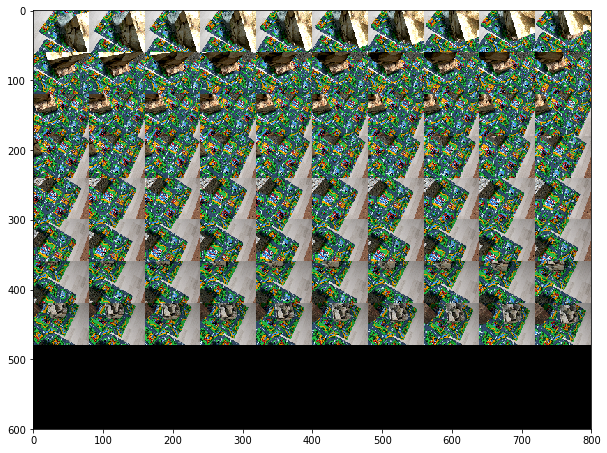

In [46]:
plt.figure(None, (10, 10))
plt.imshow(sprite_image[-h*10:, -w*10:][..., [0, 1, 2]])

In [47]:
os.path.join(img_dir, 'sprite_image.png')

'/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole/data/sprite_image.png'

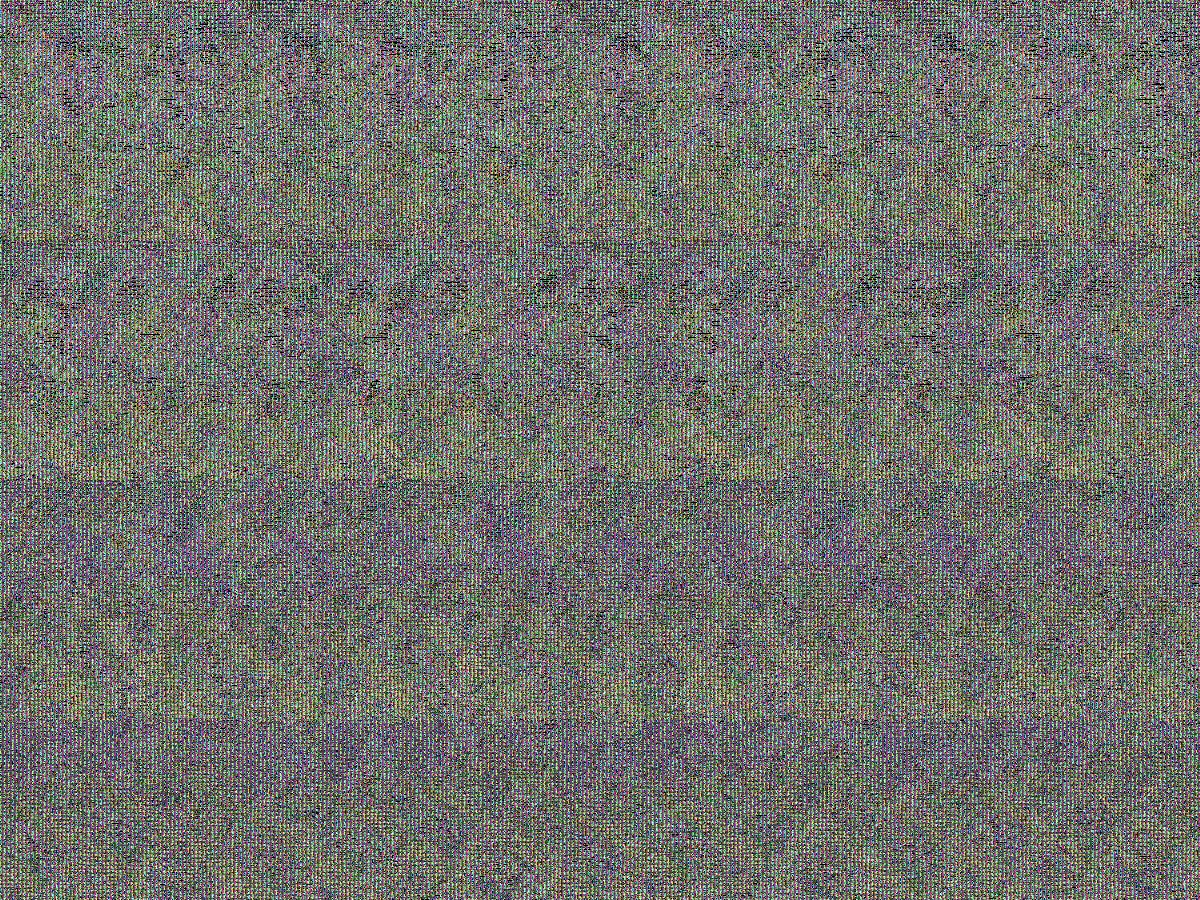

In [49]:
from PIL import Image
_=Image.fromarray(sprite_image, mode='RGB')
#toimage(sprite_image, cmin=0.0, cmax=1).save(os.path.join(img_dir, 'sprite_image.png'))

### Embedding evaluation

In [50]:
#tf.reset_default_graph() 
embeddings_1, embeddings_2, probabilities_l = [], [], []
with tf.Graph().as_default(): 
    sess = tf.Session()
    
    with slim.arg_scope(vgg.vgg_arg_scope()) as scope:

        cnt = 1
        example_images, labels =  input_pipeline(filenames_list, batch_size= FLAGS.batch_size, session=sess)
        logits, end_points = vgg.vgg_16(example_images, num_classes=1000, is_training=False)
        # print(end_points)
        embedding_1 = end_points['vgg_16/fc6']
        embedding_2 = end_points['vgg_16/fc7']
        probabilities = tf.nn.softmax(logits)

        #print('\n'.join(end_points.keys()))

        init_fn = slim.assign_from_checkpoint_fn(
            os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
            slim.get_model_variables('vgg_16'))
        

    init_fn(sess)
    sess.run(tf.global_variables_initializer())
    
    #emb12 = sess.run([embedding_1, embedding_2, probabilities])

    # Start input enqueue threads.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    try:
#         threads = []
#         for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
#             threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
#                                          start=True))
        num_iter = int(math.ceil(FLAGS.num_examples / FLAGS.batch_size))
        true_count = 0  # Counts the number of correct predictions.
        total_sample_count = num_iter * FLAGS.batch_size

        #sess.run(label_enqueue)
        step = 0
        while step < num_iter and not coord.should_stop():
#             end_epoch = False
#             if step > 0:
#                 for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
#                     #check if not enough elements in queue
#                     size = qr._queue.size().eval(session=sess)
#                     if size - FLAGS.batch_size < FLAGS.min_queue_size:
#                         end_epoch = True
#             if end_epoch:
#                 #enqueue more so that we can finish
#                 pass #sess.run(label_enqueue)
            #actually run step
            embedding_1_val, embedding_2_val, probabilities_val = sess.run([embedding_1, embedding_2, probabilities])
#                 #print(embedding_1_val, embedding_2_val, probabilities_val)
            embeddings_1 += [embedding_1_val.reshape(-1, 4096)] # D = 4096
            embeddings_2 += [embedding_2_val.reshape(-1, 4096)]
            probabilities_l += [probabilities_val[...,:5]]
            step += 1
            if not step % 10:
                print(step)
#               saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)

    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (FLAGS.num_epochs, step))
    finally:
      # When done, ask the threads to stop.
      coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

INFO:tensorflow:Restoring parameters from /home/andreikvasov/Documents/FOV/FOV problem/vgg_16.ckpt


In [21]:
all_embeddings_1 = np.concatenate(embeddings_1, axis=0)
for x in (np.where(np.prod(np.isclose(emb, all_embeddings_1), axis=1))[0] for emb in all_embeddings_1):
    print(x)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]


In [55]:
%store embeddings_1
%store embeddings_2

Stored 'embeddings_1' (list)
Stored 'embeddings_2' (list)


### Tensorboard projector and sprite load

In [56]:
%store -r embeddings_1
%store -r embeddings_2

In [65]:
with tf.Session() as sess:

    print("Start")
    N, D = len(filenames_list), 4096
    embedding_var_1 = tf.Variable(tf.random_normal([N, D]), name='image_embedding_vgg16_fc6')
    embedding_var_2 = tf.Variable(tf.random_normal([N, D]), name='image_embedding_vgg16_fc7')
    
    saver = tf.train.Saver([embedding_var_1, embedding_var_2])
    embedding_var_1.initializer.run()
    embedding_var_1.assign(np.concatenate(embeddings_1))
    
    embedding_var_2.initializer.run()
    embedding_var_2.assign(np.concatenate(embeddings_2))

    saver.save(sess, os.path.join(LOG_DIR, "embeddings_vars.ckpt"), 0)
    #saver_2.save(sess, os.path.join(LOG_DIR, "embeddings_var_2.ckpt"), 0)

    config = projector.ProjectorConfig()

    embedding_conf_1 = config.embeddings.add()
    embedding_conf_1.tensor_name = embedding_var_1.name
    
    embedding_conf_2 = config.embeddings.add()
    embedding_conf_2.tensor_name = embedding_var_2.name

    embedding_conf_1.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
    # Specify the width and height of a single thumbnail.
    embedding_conf_1.sprite.single_image_dim.extend([w, h])
    
    embedding_conf_2.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
    # Specify the width and height of a single thumbnail.
    embedding_conf_2.sprite.single_image_dim.extend([w, h])

    #print(embedding_var_1.eval(session=sess))
    summary_writer = tf.summary.FileWriter(LOG_DIR)


    projector.visualize_embeddings(summary_writer, config)
    print("End")


Start
End


In [66]:
all_embeddings_1 = np.concatenate(embeddings_1, axis=0)
all_embeddings_2 = np.concatenate(embeddings_2, axis=0)

In [61]:
img_dir

# Write in console: 
#tensorboard --logdir=[$img_dir] &

'/home/andreikvasov/Documents/FOV/FOV problem/rpg_vfr_pinhole/data'

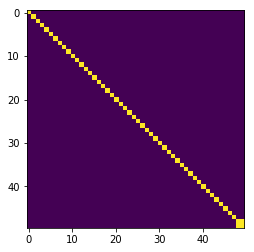

In [62]:
plt.imshow(np.prod(np.isclose(all_embeddings_1[np.newaxis, -50:, :], all_embeddings_1[-50:, np.newaxis, :]), axis=-1))

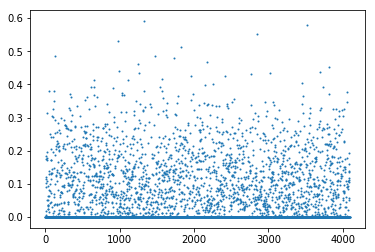

In [63]:
plt.figure()
plt.scatter(np.arange(all_embeddings_1.shape[1]), all_embeddings_1[0], s=1)

## Kernel nonpararmetric regression

In [73]:
from sklearn.decomposition import PCA

In [74]:
st, end = 0, -1
pca = PCA(n_components=0.8, random_state=0)
pca_emb_1 = pca.fit_transform(all_embeddings_1[st:end])
pca_emb_2 = pca.fit_transform(all_embeddings_2[st:end])

pca_emb_1.shape, pca_emb_2.shape

((199, 12), (199, 13))

In [75]:
pca_emb = pca_emb_1
perm_ind = np.random.permutation(np.arange(pca_emb.shape[0]))
train_ind, test_ind = perm_ind[:int(pca_emb.shape[0]*0.7)], perm_ind[int(pca_emb.shape[0]*0.7):]

In [76]:
gt_txt = pd.read_table(os.path.join(dataset_dir, 'img_groundtruth.txt'), header='infer', index_col=0, sep='\s+')

In [77]:
import pyqt_fit.nonparam_regression as smooth
from pyqt_fit import npr_methods

ImportError: No module named pyqt_fit.nonparam_regression

In [27]:
pca_emb[test_ind].T.shape

(53, 750)

In [28]:
k0 = smooth.NonParamRegression(pca_emb[train_ind].T, gt_txt['tx'].values[train_ind], 
                               method=npr_methods.LocalPolynomialKernel(q=2), bandwidth=np.eye(pca_emb.shape[1]))
k0.fit()

In [29]:
grid = np.arange(len(pca_emb[test_ind]))
res = k0(pca_emb[test_ind].T)
plt.plot(grid, res, label="Spatial Averaging", linewidth=2)
plt.legend(loc='best')

/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.94079378904e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.768091213e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.65485315623e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site

/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.27927379432e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.00187212693e-10
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.06580047407e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/si

/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.41015853109e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.0321603535e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.9437052502e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site

KeyboardInterrupt: 

# With statsmodel library

In [32]:
import statsmodels.nonparametric.kernel_regression as knr
import statsmodels.nonparametric.kernel_density as knd
import statsmodels.nonparametric.kernels as kernels

import statsmodels.api as sm

/home/andreikvasov/anaconda2/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [95]:
nn = 10
KerReg_list = []
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['tx'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['ty'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['tz'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['qx'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['qy'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['qz'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]
KerReg_list += [sm.nonparametric.KernelReg([gt_txt['qw'].values[st:end][train_ind]], [row for row in pca_emb[train_ind].T],
                                      'c'*pca_emb.shape[1], reg_type='ll', bw=np.eye(pca_emb.shape[1]))]

In [96]:
gt_txt['tx'].values[st:end][train_ind].shape, pca_emb.shape[1], pca_emb[train_ind].T.shape, Kerneg.exog.shape

((1750,), 53, (53, 1750), (53, 1750))

In [97]:
for Kerneg in KerReg_list:
    Kerneg.exog = Kerneg.exog.T
    Kerneg.endog = Kerneg.endog.T

In [98]:
res = np.concatenate([KerReg_list[i].fit().mean for i in range(len(KerReg_list))] , axis=1).T

ValueError: On entry to DLASCL parameter number 4 had an illegal value

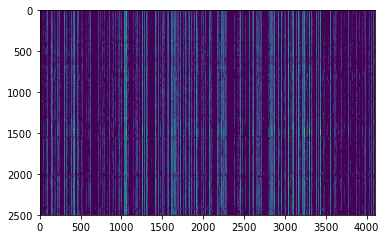

In [39]:
plt.imshow(all_embeddings_1)

### Inception example

In [ ]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

In [ ]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

In [ ]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [ ]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [ ]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the uers's loss plus any regularization losses.
    total_loss = tf.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

In [ ]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

In [ ]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(predictions, targets),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(predictions, targets)
    })

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        metric_values = slim.evaluation.evaluation_loop(
            '',ckpt_dir,None,
            num_evals=1, # Single pass over data
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.items():
      print('%s: %f' % (key, value))

In [ ]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)


In [ ]:
dataset.data_sources

In [ ]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

In [ ]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

In [ ]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

In [ ]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [ ]:
from datasets import flowers

# This might take a few minutes.
train_dir = '/tmp/tfslim_model/'
print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, batch_size=10)
  
    # Create the model:
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    tf.losses.softmax_cross_entropy(one_hot_labels, logits)
    total_loss = tf.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=1, # For speed, we just do 1 epoch
      save_summaries_secs=1)
  
    print('Finished training. Final batch loss %d' % final_loss)

In [ ]:
from datasets import flowers

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))

# READ DATA

In [61]:
FLAGS.cam_types = ['cata', 'fisheye']

In [62]:
read_data_sets(None, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_cata/groundtruth.txt
(2500, 7)
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_cata/images.txt
(2500, 2)
(2500, 2) [   1    2    3 ..., 2498 2499 2500] 5000
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_fisheye/groundtruth.txt
(2500, 7)
/home/andreikvasov/Documents/term4_research/multi_fov_dataset/rpg_urban_fisheye/images.txt
(2500, 2)
(2500, 2) [   1    2    3 ..., 2498 2499 2500] 5000


In [ ]:
class DataSet(object):
  import numpy

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True,
               seed=None):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
#     if fake_data:
#       fake_image = [1] * 784
#       if self.one_hot:
#         fake_label = [1] + [0] * 9
#       else:
#         fake_label = 0
#       return [fake_image for _ in xrange(batch_size)], [
#           fake_label for _ in xrange(batch_size)
#       ]
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part), axis=0) , numpy.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]

In [ ]:
FLAGS = None


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to(data_set, name):
    """Converts a dataset to tfrecords."""
    images = data_set.images
    labels = data_set.labels
    num_examples = data_set.num_examples

    if images.shape[0] != num_examples:
        raise ValueError('Images size %d does not match label size %d.' %
                         (images.shape[0], num_examples))
    rows = images.shape[1]
    cols = images.shape[2]
    depth = images.shape[3]

    filename = os.path.join(FLAGS.directory, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(num_examples):
        image_raw = images[index].tostring()
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(rows),
            'width': _int64_feature(cols),
            'depth': _int64_feature(depth),
            'label': _float_feature(labels[index]),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
    writer.close()


def main(unused_argv):
    # Get the data.
    data_sets = read_data_sets(FLAGS.directory, cam_types=FLAGS.cam_types,
                               dtype=tf.uint8,
                                reshape=False,
                               validation_size=0.25)

    # Convert to Examples and write the result to TFRecords.
    convert_to(data_sets.train, 'train')
    convert_to(data_sets.validation, 'validation')
    convert_to(data_sets.test, 'test')


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#       '--directory',
#       type=str,
#       default='/tmp/data',
#       help='Directory to download data files and write the converted result'
#     )
#     parser.add_argument(
#       '--validation_size',
#       type=int,
#       default=5000,
#       help="""\
#       Number of examples to separate from the training data for the validation
#       set.\
#       """
#     )
#FLAGS, unparsed = parser.parse_known_args()
#     print(FLAGS, unparsed)
FLAGS=argparse.Namespace(directory="/home/user/kvasov/multi_fov_dataset/rpg_urban_pinhole", cam_types=['pinhole'])
tf.app.run(main=main, argv=[sys.argv[0]])# + unparsed)